In [21]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDRegressor, SGDClassifier, Lasso, Ridge

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from lightgbm import LGBMRegressor, LGBMRegressor

from catboost import CatBoostRegressor, CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [22]:
all_df = pd.read_csv('data/clean_df.csv')

In [39]:
X = pd.read_csv('data/features_data.csv', index_col=0)
y = pd.read_csv('data/target_data', index_col=0)
y.shape

(5798, 9)

In [40]:
X_clean = X[~X.isna_Al2O3].drop(['isna_Al2O3', 'isna_SiO2'], axis=1)
y_clean = y[~y.isna_Al2O3].drop(['isna_Al2O3', 'isna_SiO2'], axis=1)

In [42]:
X_clean.shape

(4372, 62)

### Рассмотрим целевые переменные

In [26]:
y_clean.columns

Index(['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2'],
      dtype='object')

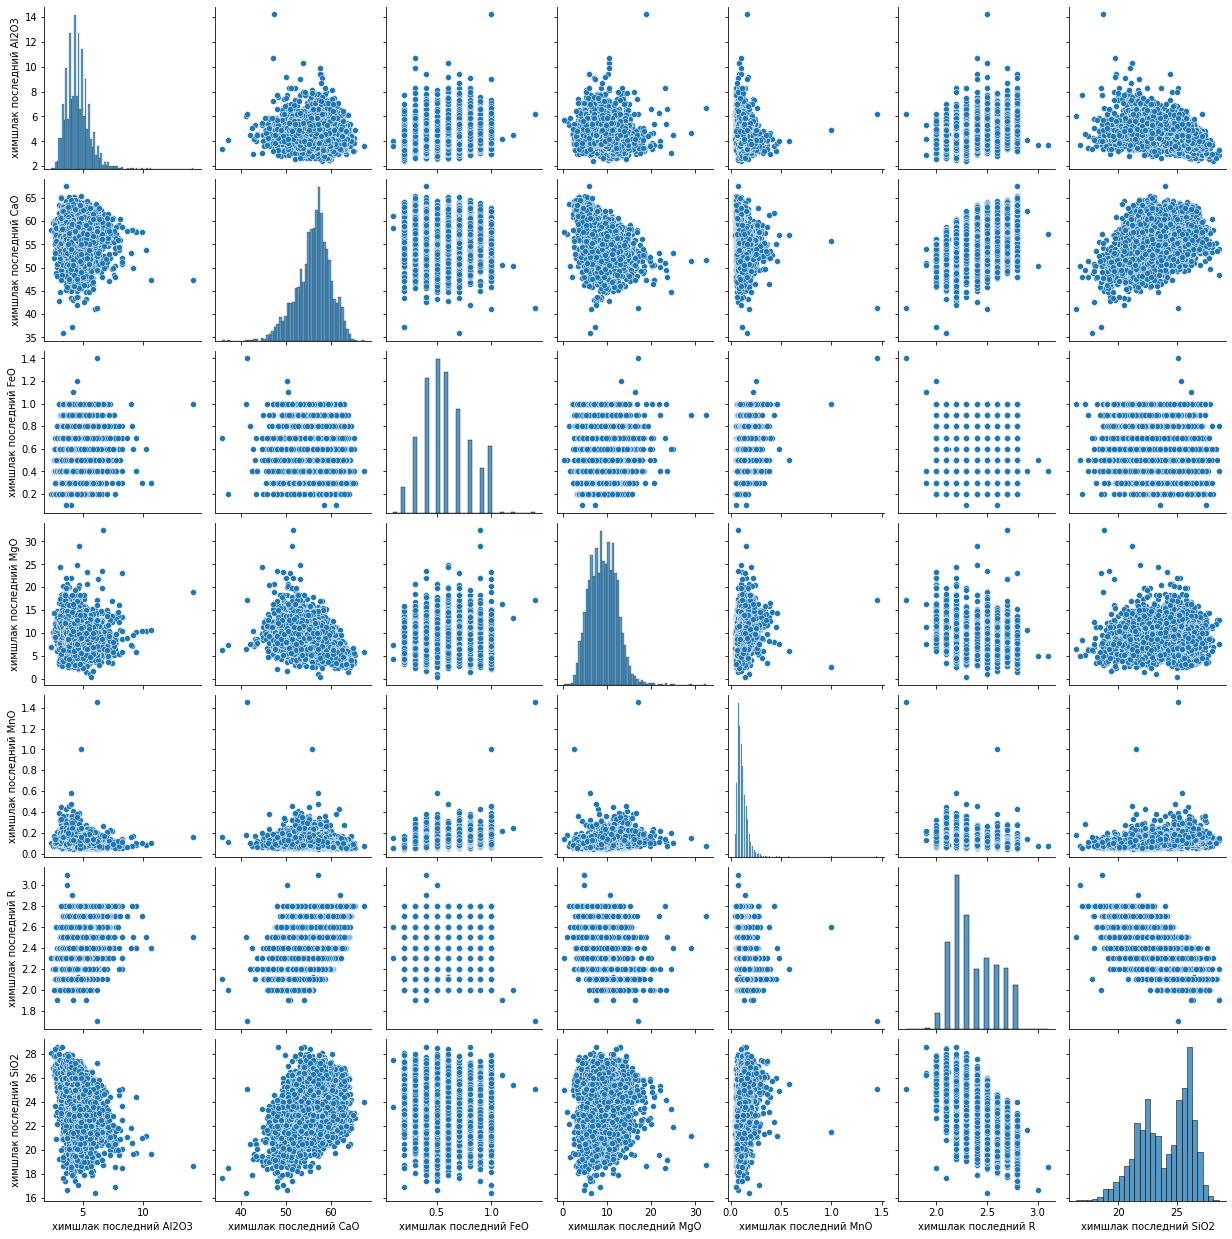

In [27]:
sns.pairplot(y_clean)

1. Химшлаки FeO и MgO имеют дискретное распредение. Для предсказывания их значений можно попробовать использовать классификацию.

2. На этапе Junior была выдвинута гипотеза:

        Гипотеза: целевые переменные можно восстановить с помощью других целевых переменных:

        Al2O3 <-> R
        Al2O3 <-> SiO2
        
        MgO <-> CaO
        MgO <-> R
        
        CaO <-> R        
        CaO <-> SiO2
        
        FeO <-> MnO

        SiO2 <-> R 

In [28]:
# all_df.corr(method='spearman')['химшлак последний FeO'].sort_values(ascending=False)


In [29]:
results_mape = pd.DataFrame(index =['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2'])
models_param = {}

In [31]:
def model_results_cross_val(X, y, model, name_model, n=5):
    global results_mape
    results_mape[name_model] = None
    for name in y.columns:
        mape = cross_val_score(model, X, y[name], cv=n, scoring='neg_mean_absolute_percentage_error')
        print(name, 'mape:', round(-mape.mean() * 100, 2))
        results_mape[name_model][name] = round(-mape.mean() * 100, 2)    
        
def model_results_with_grid_cv_cross_val(X, y, model, name_model, parameters_grid, n=5):
    global results_mape
    global models_param
    results_mape[name_model] = None
    for name in y.columns:
        grid_cv = GridSearchCV(model, param_grid=parameters_grid, cv=n, n_jobs=-1)
        grid_cv.fit(X_clean, y_clean[name])
        print("Patameters: ", grid_cv.best_params_)
        models_param.update({ '{}'.format(name_model + ' ' + name) : grid_cv.best_params_})
        model = grid_cv.best_estimator_
        mape = cross_val_score(model, X, y[name], cv=n, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        print(name, 'mape:', round(-mape.mean() * 100, 2))
        results_mape[name_model][name] = round(-mape.mean() * 100, 2)
        
def description_model_result(X, y, model, name_model):
    for name in y.columns:
        cross_val_mape = cross_val_score(model, X, y[name], scoring='neg_mean_absolute_percentage_error', cv=5)
        cross_val_mse = cross_val_score(model, X, y[name], scoring='neg_mean_squared_error', cv=5)
        print('\n', name_model, '\nmse: {}, \nmape: {}'.format(round(-cross_val_mse.mean(), 4), \
                                                               round(-100 * cross_val_mape.mean(), 2)))
        x_train, x_test, y_train, y_test = train_test_split(X, y[name], train_size=0.75)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        

        plt.scatter(y_test, y_predict)
        limit_max = max([y_test.max(), y_predict.max()])
        limit_min = min([y_test.min(), y_predict.min()])
        plt.plot([limit_min, limit_max], [limit_min, limit_max], c='r' )
        plt.xlabel('Реальное значение ' + name)
        plt.ylabel('Предсказанное значение ' + name)
        plt.title('Сравнение реальных и предказанных значений')
        plt.show()
        
def description_model_result_series(X, y, model, name_model):
    name =y.name
    cross_val_mape = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5)
    cross_val_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    print('\n', name_model, '\nmse: {}, \nmape: {}'.format(round(-cross_val_mse.mean(), 4), \
                                                               round(-100 * cross_val_mape.mean(), 2)))
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    print('\n', name_model, '\nmse: {}, \nmape: {}'.format(round(mean_squared_error(y_test, y_predict), 4), \
                                                     round(100 * mean_absolute_percentage_error(y_test, y_predict), 2)))
    plt.scatter(y_test, y_predict)
    limit_max = max([y_test.max(), y_predict.max()])
    limit_min = min([y_test.min(), y_predict.min()])
    plt.plot([limit_min, limit_max], [limit_min, limit_max], c='r' )
    plt.xlabel('Реальное значение ' + name)
    plt.ylabel('Предсказанное значение ' + name)
    plt.title('Сравнение реальных и предказанных значений')
    plt.show()

### Линейная регрессия

Линейная регрессия
химшлак последний Al2O3 mape: 11.1
химшлак последний CaO mape: 4.89
химшлак последний FeO mape: 35.72
химшлак последний MgO mape: 26.24
химшлак последний MnO mape: 30.28
химшлак последний R mape: 6.22
химшлак последний SiO2 mape: 7.01

 Линейная регрессия 
mse: 0.483, 
mape: 11.1


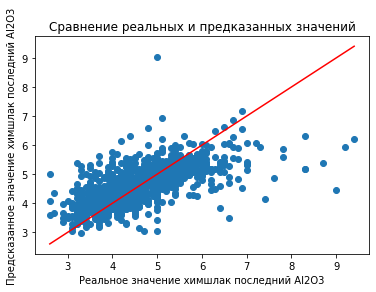


 Линейная регрессия 
mse: 11.8113, 
mape: 4.89


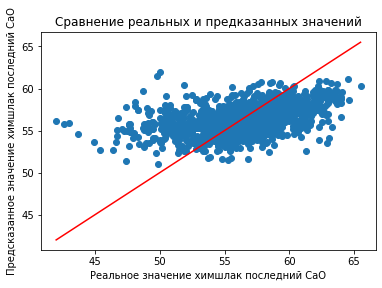


 Линейная регрессия 
mse: 0.0439, 
mape: 35.72


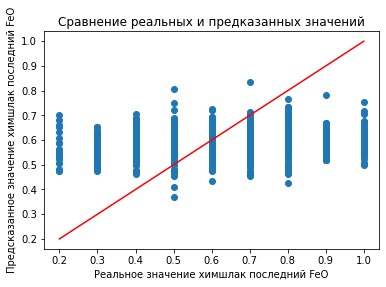


 Линейная регрессия 
mse: 6.6903, 
mape: 26.24


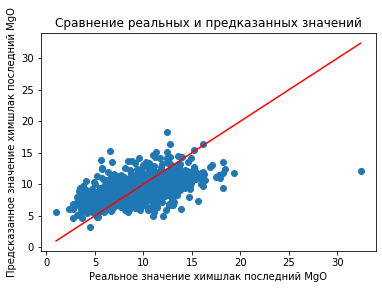


 Линейная регрессия 
mse: 0.0027, 
mape: 30.28


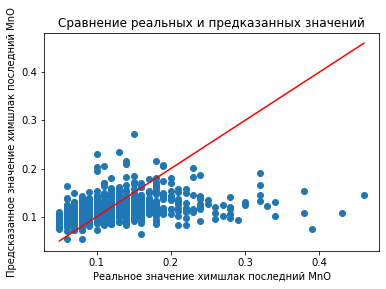


 Линейная регрессия 
mse: 0.034, 
mape: 6.22


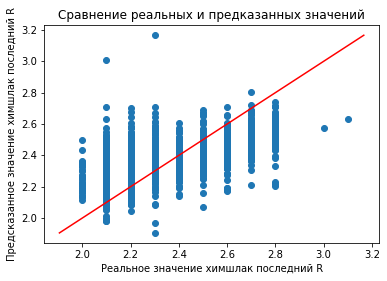


 Линейная регрессия 
mse: 4.0171, 
mape: 7.01


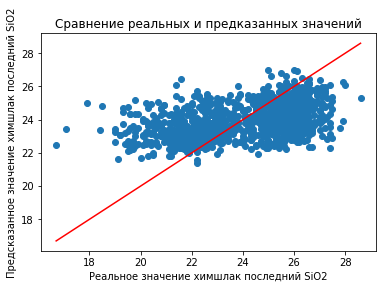

In [32]:
print('Линейная регрессия')
model_results_cross_val(X_clean, y_clean, LinearRegression(), 'Линейная регрессия')
description_model_result(X_clean, y_clean, LinearRegression(), 'Линейная регрессия')

### Lasso

In [33]:
print('Lasso')
model_results_cross_val(X_clean, y_clean, Lasso(), 'Lasso')

param = {'alpha':[0.001, 0.01, 0.02, 0.03]}
model_results_with_grid_cv_cross_val(X_clean, y_clean, Lasso(), 'Lasso_tun', param)

Lasso
химшлак последний Al2O3 mape: 16.51
химшлак последний CaO mape: 5.28
химшлак последний FeO mape: 36.3
химшлак последний MgO mape: 31.13
химшлак последний MnO mape: 35.45
химшлак последний R mape: 8.16
химшлак последний SiO2 mape: 8.28
Patameters:  {'alpha': 0.01}
химшлак последний Al2O3 mape: 11.07
Patameters:  {'alpha': 0.03}
химшлак последний CaO mape: 4.87
Patameters:  {'alpha': 0.01}
химшлак последний FeO mape: 35.97
Patameters:  {'alpha': 0.02}
химшлак последний MgO mape: 26.52
Patameters:  {'alpha': 0.01}
химшлак последний MnO mape: 34.24
Patameters:  {'alpha': 0.01}
химшлак последний R mape: 6.36
Patameters:  {'alpha': 0.01}
химшлак последний SiO2 mape: 7.03


In [ ]:
description_model_result(X_clean, y_clean, Lasso(alpha=0.01), 'Lasso')

### Ridge

In [34]:
print('Ridge')
model_results_cross_val(X_clean, y_clean, Ridge(), 'Ridge')

param = {'alpha':[0.01 ,1, 10, 100, 200, 300]}
model_results_with_grid_cv_cross_val(X_clean, y_clean, Ridge(), 'Ridge_tun', param)

Ridge
химшлак последний Al2O3 mape: 11.1
химшлак последний CaO mape: 4.89
химшлак последний FeO mape: 35.71
химшлак последний MgO mape: 26.25
химшлак последний MnO mape: 30.3
химшлак последний R mape: 6.22
химшлак последний SiO2 mape: 7.01
Patameters:  {'alpha': 1}
химшлак последний Al2O3 mape: 11.1
Patameters:  {'alpha': 300}
химшлак последний CaO mape: 4.88
Patameters:  {'alpha': 300}
химшлак последний FeO mape: 35.7
Patameters:  {'alpha': 300}
химшлак последний MgO mape: 26.87
Patameters:  {'alpha': 1}
химшлак последний MnO mape: 30.3
Patameters:  {'alpha': 300}
химшлак последний R mape: 6.28
Patameters:  {'alpha': 300}
химшлак последний SiO2 mape: 7.04


### SGDRegressor

In [35]:
print('SGDRegressor')
model_results_cross_val(X_clean, y_clean, SGDRegressor(), 'SGDRegressor')

param = {'alpha': 10.0 ** -np.arange(1, 4),
            'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
            'penalty': ['l2', 'l1'] }
model_results_with_grid_cv_cross_val(X_clean, y_clean,  SGDRegressor(), ' SGDRegressor_tun', param)

SGDRegressor
химшлак последний Al2O3 mape: 11.21
химшлак последний CaO mape: 4.94
химшлак последний FeO mape: 35.83
химшлак последний MgO mape: 26.41
химшлак последний MnO mape: 31.22
химшлак последний R mape: 6.34
химшлак последний SiO2 mape: 7.11
Patameters:  {'alpha': 0.01, 'loss': 'squared_loss', 'penalty': 'l1'}
химшлак последний Al2O3 mape: 11.07
Patameters:  {'alpha': 0.1, 'loss': 'squared_loss', 'penalty': 'l2'}
химшлак последний CaO mape: 4.89
Patameters:  {'alpha': 0.1, 'loss': 'squared_loss', 'penalty': 'l2'}
химшлак последний FeO mape: 35.7
Patameters:  {'alpha': 0.01, 'loss': 'epsilon_insensitive', 'penalty': 'l1'}
химшлак последний MgO mape: 25.53
Patameters:  {'alpha': 0.1, 'loss': 'squared_loss', 'penalty': 'l2'}
химшлак последний MnO mape: 31.35
Patameters:  {'alpha': 0.1, 'loss': 'huber', 'penalty': 'l2'}
химшлак последний R mape: 6.18
Patameters:  {'alpha': 0.1, 'loss': 'squared_loss', 'penalty': 'l2'}
химшлак последний SiO2 mape: 7.06


### RandomForestRegressor

In [ ]:
print('RandomForestRegressor')
model_results_cross_val(X_clean, y_clean, SGDRegressor(), 'RandomForestRegressor')

param = {'n_estimators': [100, 300, 500],
                  'max_depth': [1, 3, 5],
                 'max_features': ['auto', 'sqrt', 'log2']}

model_results_with_grid_cv_cross_val(X_clean, y_clean.iloc[:, 1:], RandomForestRegressor(), 'RandomForestRegressor_tun_with_ld', param)

RandomForestRegressor
химшлак последний Al2O3 mape: 11.2
химшлак последний CaO mape: 4.94
химшлак последний FeO mape: 35.98
химшлак последний MgO mape: 26.38
химшлак последний MnO mape: 30.64
химшлак последний R mape: 6.33
химшлак последний SiO2 mape: 7.05
Patameters:  {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300}
химшлак последний CaO mape: 4.91
Patameters:  {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
химшлак последний FeO mape: 35.88
Patameters:  {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
химшлак последний MgO mape: 26.59


### LGBMRegressor

In [ ]:
print('LGBMRegressor')
model_results_cross_val(X_clean, y_clean, LGBMRegressor(), 'LGBMRegressor')

param = {'num_leaves': [20, 28],
        'max_depth': [-1, 1,  3],
        'n_estimators': [100, 150, 50]}
model_results_with_grid_cv_cross_val(X_clean, y_clean, LGBMRegressor(), 'LGBMRegressor_tun', param)

### CatBoostRegressor

In [ ]:
print('CatBoostRegressor')
model_results_cross_val(X_clean, y_clean, CatBoostRegressor(verbose=False), 'CatBoostRegressor')

param = {'depth': [6, 8],
        'learning_rate' : [0.1],
        'iterations'    : [30, 50, 100]}
model_results_with_grid_cv_cross_val(X_clean, y_clean, CatBoostRegressor(verbose=False), 'CatBoostRegressor_tun', param)

In [ ]:
results_mape_data_without_ld = results_mape.copy().T
results_mape_data_without_ld.to_excel('results_mape_data_without_ld.xlsx')
results_mape_data_without_ld = pd.read_excel('results_mape_data_without_ld.xlsx', index_col=0)


In [ ]:
models_param_data_without_ld = pd.Series(models_param).copy()
models_param_data_without_ld.to_excel('models_param_data_without_ld.xlsx')
models_param_data_without_ld = pd.read_excel('models_param_data_without_ld.xlsx', index_col=0)

In [ ]:
results_mape_data_without_ld

In [ ]:
print('Лучшие оценки на данных без признаков, которые коррелирует с оставшимися больше чем corr > 0.9 \n')
for target in results_mape_data_without_ld.columns:
    col = results_mape_data_without_ld[target]
    print(target + '\n', col[col == col.min()].index.to_list()[0], '\nmape:', col.min(), '\n')
#     results_mape_data_without_ld[target].min(), results_mape_data_without_ld[target]', 'idxmin']))

### Предсказание по данным + целевым переменным, которые коррелируют  с текущей переменной

Результаты выше показывают, что переменные FeO, MgO, MnO, Al2O3 предсказываются с ошибкой mape > 10 %

#### Al2O3

In [ ]:
models_param_data_without_ld.loc[' SGDRegressor_tun химшлак последний Al2O3']

In [ ]:
description_model_result_series(X_clean, y_clean['химшлак последний Al2O3'], \
                         SGDRegressor(alpha=0.01, loss='squared_loss', penalty='l1'), 'SGDRegressor')

In [ ]:
X_with_target = X_clean.copy().merge(y_clean['химшлак последний R'],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний Al2O3'], \
                         SGDRegressor(alpha=0.01, loss='squared_loss', penalty='l1'), 'SGDRegressor')

In [ ]:
#Восстанавливать Al2O3 по SiO2 + R плохая идея
#Восстанавливать Al2O3 по  R плохая идея
#Восстанавливать Al2O3 по  MgO или MnO плохая идея
#Восстанавливать Al2O3 по  R + MgO или R + MnO хорошая идея. Выбрала R + MgO ,
# на крос валидации дает немного лучше результат
X_with_target = X_clean.copy().merge(y_clean[['химшлак последний R', 'химшлак последний MgO'] ],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний Al2O3'], \
                         SGDRegressor(alpha=0.01, loss='squared_loss', penalty='l1'), 'SGDRegressor')
results_mape.loc['химшлак последний Al2O3', ' SGDRegressor_tun + R + MgO'] = round(-100 * \
                                                                               cross_val_score(SGDRegressor(alpha=0.01, loss='squared_loss', penalty='l1'),
                                                                                X_with_target, y_clean['химшлак последний Al2O3'], \
                                                                                scoring='neg_mean_absolute_percentage_error').mean(), 2)

#### FeO

In [ ]:
models_param_data_without_ld.loc[' SGDRegressor_tun химшлак последний FeO'].values

In [ ]:
description_model_result_series(X_clean, y_clean['химшлак последний FeO'], \
                         SGDRegressor(alpha=0.001, loss='squared_loss', penalty='l1'), 'SGDRegressor')

In [ ]:
X_with_target = X_clean.copy().merge(y_clean['химшлак последний MnO'],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний FeO'], \
                         SGDRegressor(alpha=0.001, loss='squared_loss', penalty='l1'), 'SGDRegressor_tun')

results_mape.loc['химшлак последний FeO', ' SGDRegressor_tun + MnO'] = round(-100 * \
                                                                               cross_val_score(SGDRegressor(alpha=0.001, loss='squared_loss', penalty='l1'),
                                                                                X_with_target, y_clean['химшлак последний FeO'], \
                                                                                scoring='neg_mean_absolute_percentage_error').mean(), 2)

In [ ]:
param = {'alpha': 10.0 ** -np.arange(1, 3),
            'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
            'penalty': ['l2', 'l1'] }
model_results_with_grid_cv_cross_val(X_with_target, y_clean[['химшлак последний FeO', 'химшлак последний Al2O3',\
                                                            'химшлак последний MgO']],\
                                                      SGDRegressor(), ' SGDRegressor_tun + MnO', param)

In [ ]:
param = {'depth': [6, 8],
        'learning_rate' : [0.1],
        'iterations'    : [50, 100, 150]}
model_results_with_grid_cv_cross_val(X_with_target, y_clean[['химшлак последний FeO', 'химшлак последний Al2O3',\
                                                            'химшлак последний MgO']],\
                                                      CatBoostRegressor(verbose=False), ' CatboostReg_tun + MnO', param)

In [ ]:
description_model_result_series(X_clean, y_clean['химшлак последний FeO'], CatBoostRegressor(verbose=False, depth=6, iterations=50, learning_rate=0.1), 'Lasso_tun')

Попробуем решить эту задачу методом класификации

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
y_clean['химшлак последний FeO'].hist(bins=10)

In [ ]:
y_clf.unique()

In [ ]:
le = LabelEncoder()
y_clf = y_clean['химшлак последний FeO'].apply(lambda x: 0.3 if x <= 0.3 else x).copy()
y_clf = y_clf.apply(lambda x: 1 if x > 1 else x)
le.fit(y_clf)
y_clf = pd.Series(le.transform(y_clf), name='le_FeO')
X_with_target = X_clean.copy().merge(y_clean['химшлак последний MnO'], how='right', left_index=True, right_index=True )

reverse_col = {}
for i in range(8):
    reverse_col.update({i: le.classes_[i]})

model = KNeighborsClassifier(n_neighbors=8, n_jobs=-1, weights='distance')
x_train, x_test, y_train, y_test = train_test_split(X_with_target, y_clf, train_size=0.75)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
print(str(model) + '\naccuracy:', accuracy_score(y_predict, y_test))

print('mape: ', round(100 * mean_absolute_percentage_error(pd.Series(y_predict).map(reverse_col), y_test.map(reverse_col)), 2))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
XPCAreduced = pca.fit_transform(X_with_target)

model = KNeighborsClassifier(n_neighbors=8, n_jobs=-1, weights='distance')
x_train, x_test, y_train, y_test = train_test_split(XPCAreduced, y_clf, train_size=0.75)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
print(str(model) + ' PCA '+ '\naccuracy:', accuracy_score(y_predict, y_test))
    
print('mape: ', round(100 * mean_absolute_percentage_error(pd.Series(y_predict).map(reverse_col), y_test.map(reverse_col)), 2))

In [ ]:
model = RandomForestClassifier()
x_train, x_test, y_train, y_test = train_test_split(X_with_target, y_clf, train_size=0.75)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
print(str(model) + '\naccuracy:', accuracy_score(y_predict, y_test))

print('mape: ', round(100 * mean_absolute_percentage_error(pd.Series(y_predict).map(reverse_col), y_test.map(reverse_col)), 2))

Классификатор не дал более точныех результатов, чем регрессия

#### MgO

In [ ]:
description_model_result_series(X_clean, y_clean['химшлак последний MgO'], \
                         LinearRegression(), 'LinearRegression')

In [ ]:
X_with_target = X_clean.copy().merge(y_clean['химшлак последний R'],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний MgO'], \
                          LinearRegression(), 'LinearRegression')

In [ ]:
X_with_target = X_clean.copy().merge(y_clean[['химшлак последний R', 'химшлак последний CaO']],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний MgO'], \
                          LinearRegression(), 'LinearRegression')

In [ ]:
y_clean.columns

In [ ]:
X_with_target = X_clean.copy().merge(y_clean[['химшлак последний R', 'химшлак последний CaO'] ],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний MgO'], \
                         LGBMRegressor(), 'LGBMRegressor')
results_mape.loc['химшлак последний MgO', 'LGBMRegressor + R + CaO'] = round(-100 * \
                                                                               cross_val_score(LGBMRegressor(),
                                                                                X_with_target, y_clean['химшлак последний MgO'], \
                                                                                scoring='neg_mean_absolute_percentage_error').mean(), 2)

#### MnO

In [ ]:
description_model_result_series(X_clean, y_clean['химшлак последний MnO'], \
                         LinearRegression(), 'LinearRegression')

In [ ]:
X_with_target = X_clean.copy().merge(y_clean['химшлак последний R'],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний MnO'], \
                          LinearRegression(), 'LinearRegression')

In [ ]:
X_with_target = X_clean.copy().merge(y_clean[['химшлак последний R', 'химшлак последний MgO']],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний MnO'], \
                          LinearRegression(), 'LinearRegression')

In [ ]:
X_with_target = X_clean.copy().merge(y_clean[['химшлак последний R', 'химшлак последний MgO'] ],how='right', left_index=True, right_index=True )
description_model_result_series(X_with_target, y_clean['химшлак последний Al2O3'], \
                            CatBoostRegressor(verbose=False, depth=6, iterations=100 ),\
                                'CatBoostRegressor + R + MgO')

# description_model_result_series(X_with_target, y_clean['химшлак последний MnO'], \
#                             CatBoostRegressor(verbose=False), 'CatBoostRegressor')
# results_mape.loc['химшлак последний MnO', 'CatBoostRegressor + R + MgO'] = round(-100 * \
#                                                                                cross_val_score(CatBoostRegressor(verbose=False),
#                                                                                 X_with_target, y_clean['химшлак последний MnO'], \
#                                                                                 scoring='neg_mean_absolute_percentage_error').mean(), 2)

In [ ]:
param = {'depth': [6, 8, 10],
        'iterations'    : [30, 50, 100, 150]}
model_results_with_grid_cv_cross_val(X_with_target, y_clean[['химшлак последний MnO', 'химшлак последний Al2O3']],\
                                                      CatBoostRegressor(verbose=False, learning_rate=0.1), 'CatBoostRegressor_tun + R + MgO', param)

In [ ]:
param = {'alpha':[0.01 ,1, 10, 100, 200, 300]}
model_results_with_grid_cv_cross_val(X_with_target, y_clean[['химшлак последний MnO', 'химшлак последний Al2O3']],\
                                                      Ridge(), 'Ridge_tun + R + MgO', param)

In [ ]:
# results_mape.copy().T.to_excel('results_mape_without_ld_with_target.xlsx')
# pd.Series(models_param_with_target).to_exel('models_param_without_ld_with_target.xlsx')
# results_mape.copy().T

In [ ]:
### Результаты
results_mape_data_without_ld_with_target = results_mape.copy().T
for target in results_mape_data_without_ld_with_target.columns:
    col = results_mape_data_without_ld_with_target[target]
    print(target + '\n', col[col == col.min()].index.to_list(), '\nmape:', col.min(), '\n')
#     results_mape_data_without_ld[target].min(), results_mape_data_without_ld[target]', 'idxmin']))

In [ ]:
# models_param_with_target = pd.Series(models_param).iloc[:-1]
# for i in models_param_with_target.index:
#     print(i, models_param_with_target[i])

In [ ]:
print('Лучшие результаты')
all_mape = pd.concat([results_mape_data_without_ld, results_mape_data_without_ld_with_target])
for target in all_mape.columns:
    col = all_mape[target]
    print(target + '\n', col[col == col.min()].index.to_list(), '\nmape:', col.min(), '\n')

### Отчет по этапу Middle

# Результат

Для предсказания целевых переменных ипользовались следующие методы:

    Линейная регрессия (Linear regression), Линейная регрессия с регуляризацией 1ого порядка (Lasso),   
    Линейная регрессия с регуляризацией 2ого порядка (Ridge),  
    Случайны лес (RandomForestRegressor),    
    CatBoostRegressor, LGBMRegressor, SGDRegressor
    
На первом этапе для предсказания целевых переменных я ипользовала только имеющиеся признаки и подбирала параметры моделей. Результаты предсказания оказались точны для СaO, R, SiO2. На кросс-валидации средняя оценка MAPE была меньше 7 %.

Для остальных целевых переменных я решила проверить гипотезу, сформированную на первом этапе: между целевыми перемеными есть зависимость. К пространству признаков я добавляла данные, известные для наиболее коррелеруемых последних шлаков с зависимой переменной. 
Оценка MAPE уменьшилась.

    химшлак последний Al2O3
        SGDRegressor_tun          CatBoostRegressor_tun + R + MgO
        mape: 10.99               mape: 10.13

    химшлак последний FeO        
        SGDRegressor_tun          CatboostReg_tun + MnO
        mape: 35.6                mape: 33.52

    химшлак последний MgO         
     Линейная регрессия           LGBMRegressor + R + CaO
    mape: 25.92                   mape: 21.1

    химшлак последний MnO        
     Линейная регрессия           Ridge_tun + R + MgO
    mape: 29.84                   mape: 25.95

Для FeO ошибка оставалась высокой, поэтому я решили попробовать другой подход. Химшлак последний FeO это дискретная величина (я оставила 8 классов, потому что были значения переменной, которые встречались меньше 10 раз)

Для задачи классификации я использовала KNeighborsClassifier, SGDClassifier, RandomForestClassifier. Оценки MAPE на кроссвалидации давали оценки хуже, чем имеются на данный момент. Также пробовала понизить размерность признаков с помощью метода главных компонент, но это не помогло.


    
Для предсказания целевых переменных использовалось два датасета. В одном были все признаки, оставшиеся после предобработки данных, а во втором удалены признаки, которые коррелировали с остальными (corr > 0.9). Оценка MAPE (mean percentage error) ипользуемых моделей показали, что без линейнозависимых признаков модели более точны. 

In [ ]:
print('Модели с самой низкой ошибкой')
results = pd.read_excel('mape_end.xlsx', index_col=0, skiprows=1)
results.loc['FeO', 'Параметры'] = [{'depth': 6, 'iterations': 50, 'learning_rate': 0.1}]
results